In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm.notebook import tqdm


In [0]:
!mkdir covid_data

In [0]:
from google.colab import drive
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/Copy of Assignment 5 Dataset.zip" -d covid_data;

In [19]:
!nvidia-smi

Sat Apr 25 05:18:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    27W /  70W |   5479MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Load Dataset usign torchvision image loader

In [0]:
data_dir = 'covid_data/Assignment 5 Dataset'

In [6]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/validation', transform=val_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=60, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=60, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=60, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


In [7]:
print(train_data)
print(val_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 12000
    Root location: covid_data/Assignment 5 Dataset/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 1500
    Root location: covid_data/Assignment 5 Dataset/validation
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 1500
    Root location: covid_data/Assignment 5 Dataset/test
    StandardTransform
Transform: Com

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


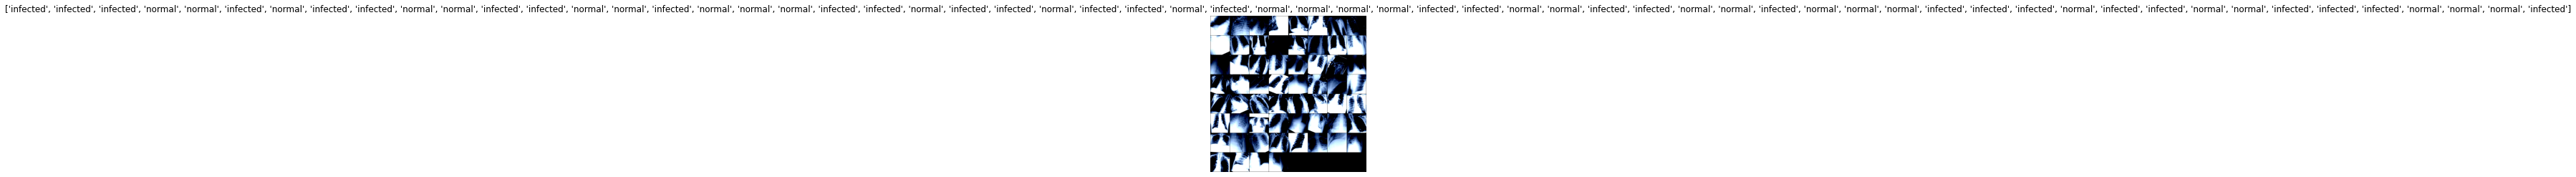

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

## VGG16 Initialization

In [95]:
# Task1
# vgg16 = models.vgg16(pretrained=True)
# num_features = vgg16.classifier[0].in_features
# features = list(vgg16.classifier.children())[:4] 
# features.extend([nn.Linear(num_features, 110)])
# features.extend([nn.Linear(110, len(class_names))])
# features = vgg16.classifier[:3]
# features[0] = nn.Linear(in_features=num_features, out_features=110)
# features[2] = nn.Linear(in_features=110, out_features=2)

# vgg16.classifier = nn.Sequential(*features)
# for param in vgg16.features.parameters():
#     param.requires_grad = False
# out_dir = './gdrive/My Drive/Deep Learning Assignment 5/models/Task1/'

# print(vgg16)
# print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

# Task2a:
# vgg16 = models.vgg16(pretrained=True)
# num_features = vgg16.classifier[0].in_features
# features = vgg16.classifier[:3]
# features[0] = nn.Linear(in_features=num_features, out_features=110)
# features[2] = nn.Linear(in_features=110, out_features=2)
# vgg16.classifier = nn.Sequential(*features)
# for param in vgg16.features[:17].parameters(): # freezing 7 conv layers, and remaining 6 are unfrozen
#     param.requires_grad = False
# out_dir = './gdrive/My Drive/Deep Learning Assignment 5/models/Task2a/'

# Task2b:
# vgg16 = models.vgg16(pretrained=True)
# num_features = vgg16.classifier[0].in_features
# features = vgg16.classifier[:3]
# features[0] = nn.Linear(in_features=num_features, out_features=110)
# features[2] = nn.Linear(in_features=110, out_features=2)
# vgg16.classifier = nn.Sequential(*features)
# for param in vgg16.features[:10].parameters(): # freezing 4 conv layers, and remaining 9 are unfrozen
#     param.requires_grad = False
# out_dir = './gdrive/My Drive/Deep Learning Assignment 5/models/Task2b/'

# Task2-final: 
vgg16 = models.vgg16(pretrained=True)
num_features = vgg16.classifier[0].in_features
features = vgg16.classifier[:3]
features[0] = nn.Linear(in_features=num_features, out_features=110)
features[2] = nn.Linear(in_features=110, out_features=2)
vgg16.classifier = nn.Sequential(*features)
out_dir = './gdrive/My Drive/Deep Learning Assignment 5/models/Task_final/'

total_params = sum(p.numel() for p in vgg16.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in vgg16.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

17,474,700 total parameters.
17,474,700 training parameters.


In [96]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
from torchvision import models
from torchsummary import summary
summary(vgg16, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Loss fucntion and optimizer

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

### Training

In [0]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

In [101]:
for epoch in range(10,Epochs+1):  # loop over the dataset multiple times
    vgg16.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()));
        train_running_loss += loss.item()

    train_loss.append(train_running_loss/ len(trainloader))
    train_acc.append(100*(train_correct/train_total))

    pbar = tqdm(enumerate(valloader))
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16(inputs)               #----> forward pass
            loss = criterion(outputs, labels)   #----> compute loss
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss.append(val_running_loss/ len(valloader))
    val_acc.append(100*(val_correct/val_total))

    print('Train Epoch: {} \t Train Loss: {:.6f} Train Accuracy : {:.2f} \
                           \n Valid Loss: {:.6f} Valid Accuracy : {:.2f} '.format( epoch, 
                            train_loss[epoch], train_acc[epoch], 
                            val_loss[epoch], val_acc[epoch]))

    torch.save(vgg16.state_dict(), out_dir + 'vgg16_ft_' + str(epoch+1) +  '.pth')

print('Finished Training')


Train Epoch: 10 	 Train Loss: 0.191571 Train Accuracy : 92.49                            
 Valid Loss: 0.218310 Valid Accuracy : 91.20 
Finished Training


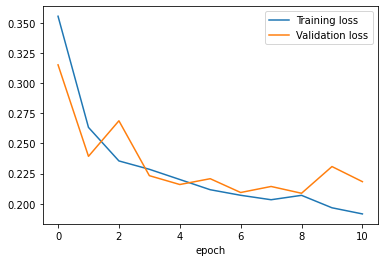

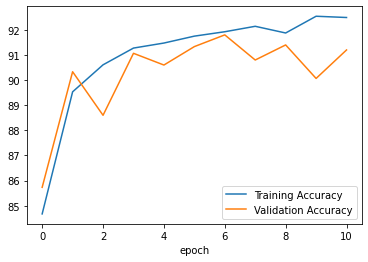

In [102]:
plt.figure()
plt.plot(train_loss, label = "Training loss")
plt.plot(val_loss, label = "Validation loss")
plt.xlabel("epoch")
plt.legend(loc='best')

plt.figure()
plt.plot(train_acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.xlabel("epoch")
plt.legend(loc='best')


### Testing

In [0]:
dataiter = iter(valloader)
images, labels = dataiter.next()
# show_databatch(images, labels)

In [117]:
images1, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images1)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(int(len(images)/2))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(int(len(images)/2))))
print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(int(len(images)/2),len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(int(len(images)/2),len(images))))

Predicted:  normal infected normal normal infected normal normal infected infected normal infected infected normal infected normal normal infected normal normal normal normal normal infected normal normal normal normal normal infected infected
Ground Truth:  normal infected normal normal infected normal infected infected infected normal infected infected normal infected normal normal infected normal normal normal normal normal infected infected normal normal normal normal infected normal
Predicted:  normal normal normal normal normal normal normal infected normal normal normal normal normal infected normal normal normal infected infected normal normal normal normal normal normal infected infected infected normal infected
Ground Truth:  normal normal normal normal normal normal normal infected normal normal normal normal normal infected normal normal normal infected infected normal normal normal normal normal normal infected infected infected normal infected


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


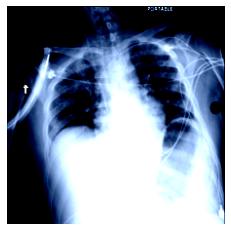

In [121]:
def show_databatch1(inputs):#, classes):
    out = torchvision.utils.make_grid(inputs)
    # imshow(out, title=[class_names[x] for x in classes])
    imshow(out)

show_databatch1(images[29])

Training Set

Accuracy of the network on the Training images: 91 %
F1 score: 0.9341236696753334
Precision: 0.8929813264649066
Recall: 0.9792402203078662


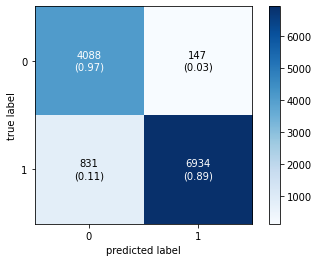

In [103]:
import itertools
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from mlxtend.plotting import plot_confusion_matrix

nb_classes = len(class_names)

correct = 0
total = 0
device = torch.device("cuda")
vgg16 = vgg16.to('cuda')
pred = []
orig = []
with torch.no_grad():
    vgg16.eval()
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred.extend(predicted)
        orig.extend(labels)

print('Accuracy of the network on the Training images: %d %%' % (100 * correct / total))
print('F1 score: {}'.format(f1_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
print('Precision: {}'.format(precision_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
print('Recall: {}'.format(recall_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
cm = confusion_matrix(torch.FloatTensor(pred), torch.FloatTensor(orig))
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()


Validation Set

Accuracy of the network on the Validation images: 91 %
F1 score: 0.9280261723009815
Precision: 0.8967334035827187
Recall: 0.9615819209039548


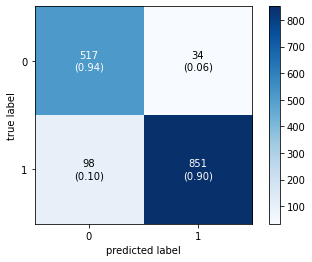

In [104]:
import itertools
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from mlxtend.plotting import plot_confusion_matrix

nb_classes = len(class_names)

correct = 0
total = 0
device = torch.device("cuda")
vgg16 = vgg16.to('cuda')
pred = []
orig = []
with torch.no_grad():
    vgg16.eval()
    for data in valloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred.extend(predicted)
        orig.extend(labels)

print('Accuracy of the network on the Validation images: %d %%' % (100 * correct / total))
print('F1 score: {}'.format(f1_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
print('Precision: {}'.format(precision_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
print('Recall: {}'.format(recall_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
cm = confusion_matrix(torch.FloatTensor(pred), torch.FloatTensor(orig))
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()


Test Set

Accuracy of the network on the Testing images: 97 %
F1 score: 0.9750415973377704
Precision: 0.9575163398692811
Recall: 0.9932203389830508


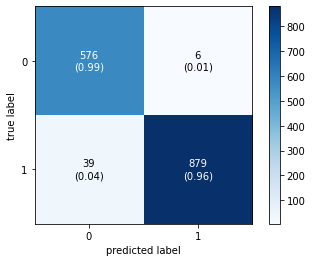

In [105]:
import itertools
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from mlxtend.plotting import plot_confusion_matrix

nb_classes = len(class_names)

correct = 0
total = 0
device = torch.device("cuda")
vgg16 = vgg16.to('cuda')
pred = []
orig = []
with torch.no_grad():
    vgg16.eval()
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred.extend(predicted)
        orig.extend(labels)

print('Accuracy of the network on the Testing images: %d %%' % (100 * correct / total))
print('F1 score: {}'.format(f1_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
print('Precision: {}'.format(precision_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
print('Recall: {}'.format(recall_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
cm = confusion_matrix(torch.FloatTensor(pred), torch.FloatTensor(orig))
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()


## Resnet

In [0]:
# # Task1
# resnet18 = models.resnet18(pretrained=True)
# fc_layers = []
# fc_layers.extend([nn.Linear(in_features=512, out_features=110)])
# fc_layers.extend([nn.ReLU(inplace=True)])
# fc_layers.extend([nn.Linear(in_features=110, out_features=2)])
# for param in resnet18.parameters():
#     param.requires_grad = False
# resnet18.fc = nn.Sequential(*fc_layers)
# out_dir = './gdrive/My Drive/Deep Learning Assignment 5/models/Task1/'


# Task2 final
resnet18 = models.resnet18(pretrained=True)
fc_layers = []
fc_layers.extend([nn.Linear(in_features=512, out_features=110)])
fc_layers.extend([nn.ReLU(inplace=True)])
fc_layers.extend([nn.Linear(in_features=110, out_features=2)])
resnet18.fc = nn.Sequential(*fc_layers)
out_dir = './gdrive/My Drive/Deep Learning Assignment 5/models/Task_final/'


In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

In [0]:
rtrain_loss = []
rval_loss = []
rtrain_acc = []
rval_acc = []


In [71]:
for epoch in range(15, Epochs+10):  # loop over the dataset multiple times
    resnet18.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet18(inputs)               #----> forward pass

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()));
        train_running_loss += loss.item()

    rtrain_loss.append(train_running_loss/ len(trainloader))
    rtrain_acc.append(100*(train_correct/train_total))

    pbar = tqdm(enumerate(valloader))
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18(inputs)               #----> forward pass
            loss = criterion(outputs, labels)   #----> compute loss
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    rval_loss.append(val_running_loss/ len(valloader))
    rval_acc.append(100*(val_correct/val_total))

    print('Train Epoch: {} \t Train Loss: {:.6f} Train Accuracy : {:.2f} \
                           \n Valid Loss: {:.6f} Valid Accuracy : {:.2f} '.format( epoch, 
                            rtrain_loss[epoch], rtrain_acc[epoch], 
                            rval_loss[epoch], rval_acc[epoch]))

    torch.save(resnet18.state_dict(), out_dir + 'resnet18_ft_' + str(epoch+1) +  '.pth')

print('Finished Training')


Train Epoch: 15 	 Train Loss: 0.215138 Train Accuracy : 91.32                            
 Valid Loss: 0.253156 Valid Accuracy : 89.47 



Train Epoch: 16 	 Train Loss: 0.205096 Train Accuracy : 92.12                            
 Valid Loss: 0.271469 Valid Accuracy : 89.93 



Train Epoch: 17 	 Train Loss: 0.205729 Train Accuracy : 91.96                            
 Valid Loss: 0.249991 Valid Accuracy : 90.27 



Train Epoch: 18 	 Train Loss: 0.199308 Train Accuracy : 92.46                            
 Valid Loss: 0.251971 Valid Accuracy : 90.00 



Train Epoch: 19 	 Train Loss: 0.198419 Train Accuracy : 92.05                            
 Valid Loss: 0.247975 Valid Accuracy : 90.20 
Finished Training


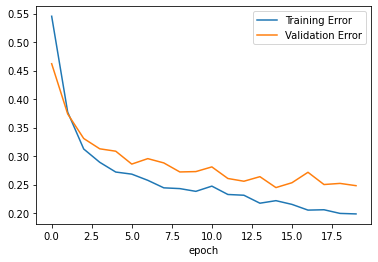

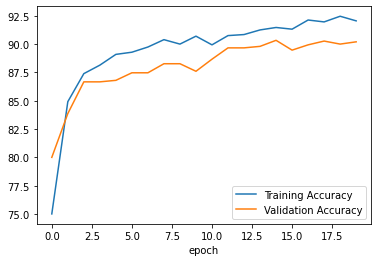

In [72]:
plt.figure()
plt.plot(rtrain_loss, label = "Training Error")
plt.plot(rval_loss, label = "Validation Error")
plt.xlabel("epoch")
plt.legend(loc='best')

plt.figure()
plt.plot(rtrain_acc, label = "Training Accuracy")
plt.plot(rval_acc, label = "Validation Accuracy")
plt.xlabel("epoch")
plt.legend(loc='best')

Accuracy of the network on the Training images: 88 %
F1 score: 0.9117088814713005
Precision: 0.8495974627958038
Recall: 0.9836181330320576


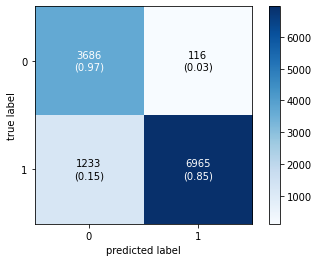

In [73]:
import itertools
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from mlxtend.plotting import plot_confusion_matrix

nb_classes = len(class_names)

correct = 0
total = 0
device = torch.device("cuda")
resnet18 = resnet18.to('cuda')
pred = []
orig = []
with torch.no_grad():
    resnet18.eval()
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred.extend(predicted)
        orig.extend(labels)

print('Accuracy of the network on the Training images: %d %%' % (100 * correct / total))
print('F1 score: {}'.format(f1_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
print('Precision: {}'.format(precision_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
print('Recall: {}'.format(recall_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
cm = confusion_matrix(torch.FloatTensor(pred), torch.FloatTensor(orig))
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()


Validation Set

Accuracy of the network on the Validation images: 91 %
F1 score: 0.927023945267959
Precision: 0.9355581127733027
Recall: 0.9186440677966101


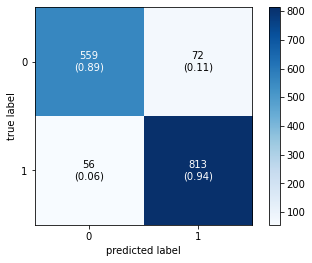

In [76]:
correct = 0
total = 0
device = torch.device("cuda")
resnet18 = resnet18.to('cuda')
pred = []
orig = []
with torch.no_grad():
    resnet18.eval()
    for data in valloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred.extend(predicted)
        orig.extend(labels)

print('Accuracy of the network on the Validation images: %d %%' % (100 * correct / total))
print('F1 score: {}'.format(f1_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
print('Precision: {}'.format(precision_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
print('Recall: {}'.format(recall_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
cm = confusion_matrix(torch.FloatTensor(pred), torch.FloatTensor(orig))
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()


Test Set

Accuracy of the network on the Testing images: 96 %
F1 score: 0.9707536557930259
Precision: 0.9664053751399776
Recall: 0.9751412429378531


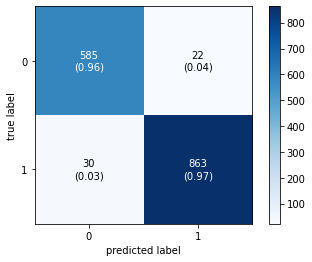

In [77]:
correct = 0
total = 0
device = torch.device("cuda")
resnet18 = resnet18.to('cuda')
pred = []
orig = []
with torch.no_grad():
    resnet18.eval()
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred.extend(predicted)
        orig.extend(labels)

print('Accuracy of the network on the Testing images: %d %%' % (100 * correct / total))
print('F1 score: {}'.format(f1_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
print('Precision: {}'.format(precision_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
print('Recall: {}'.format(recall_score(torch.FloatTensor(orig), torch.FloatTensor(pred))))
cm = confusion_matrix(torch.FloatTensor(pred), torch.FloatTensor(orig))
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()


In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# show_databatch(images, labels)


In [93]:
images1, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images1)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(int(len(images)/2))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(int(len(images)/2))))
print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(int(len(images)/2),len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(int(len(images)/2),len(images))))

Predicted:  normal infected infected infected infected normal infected infected infected normal infected infected infected infected normal normal normal infected infected normal normal infected infected infected normal normal infected infected normal normal
Ground Truth:  normal infected infected infected infected normal infected infected infected normal normal infected infected infected normal normal normal infected infected normal normal infected infected infected normal normal infected infected normal normal
Predicted:  infected normal infected normal normal normal normal normal normal normal normal infected normal normal normal normal infected normal infected normal infected normal normal infected normal infected normal infected infected normal
Ground Truth:  infected infected infected normal normal normal normal normal normal normal normal infected normal normal normal normal infected normal infected normal infected normal normal infected normal infected normal infected infected n

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


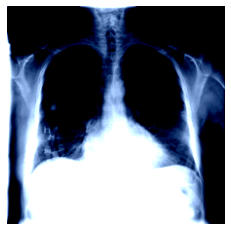

In [94]:
show_databatch1(images[10])